# Parametrized LCA: Hydrogen production via electrolysis
The following code demonstrates the steps to obtain LCA results based on foreground and background parameters such as stack type, stack lifetime, BoP lifetime, stack efficiency, capacity factor, and electricity modeling choice.
This file serves as the first step in understanding the calculation and structure of the Streamlit web app. Once you successfully run this code without errors, you'll be prepared to uderstand the calculation in the background of the Streamlit app.
- Functional unit: 1 kg of hydrogen gaseous

### Import the necessary libraries for this project:

In [1]:
import lca_algebraic as agb
from lca_algebraic import *
from io import StringIO
from urllib.request import urlopen
from six import BytesIO
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker 
import re
import seaborn as sns
import numpy as np

### Open the brightway project in which you have loaded the databases previously:

In [2]:
bw.projects.set_current("name_your_project")

### Create a user db to store modified acticites:

In [3]:
USER_DB = 'user-db'
agb.resetDb(USER_DB) # by using this function you guarantee that persistent modifications 
agb.resetParams()    # in DB or parameters affect the results of you current assessment

[WARNING] Db user-db was here. Reseting it


### Foreground parameters:
The foreground parameters selected for this assessment include: The stack life time, the balance of plant life time, the efficiency of the stacks, the capacity factor of the system and the share of PV electricity supplied to the system.

In [4]:
stack_LT = agb.newFloatParam(
    "stack_LT",
    distrib=agb.DistributionType.TRIANGLE, #120000 represents the most likely life time of stacks into the future
    default=120000, min=30000, max=150000, #30000 hours represents stacks prematurely out of service whereas 150000 represents an optimistic future 
    label="Stack lifetime",
    description="evolution of the stack lifetime",
    unit=" ")

BoP_LT_y = agb.newFloatParam(
    "BoP_LT_y",
    distrib=agb.DistributionType.TRIANGLE, #30 years represents the most likely life time of a plant
    default=30, min=5, max=40, #5 years represents situations where premature closure happened whereas 40 years represents an optimistic view
    label="BoP lifetime",
    description="evolution of the BoP lifetime in years",
    unit=" ")

eff = agb.newFloatParam(
    "eff",
    distrib=agb.DistributionType.TRIANGLE, #0.72 represents the most likely efficiency of an electrolyzer during its entire lifetime
    default=0.72, min=0.56, max=0.90,  # 0.9 is the thermodinamic limit, while 0.56 is one of the lowest efficiencies reported
    label="Stack efficiency",
    description="evolution of the stack efficiency",
    unit=" ")

cf = agb.newFloatParam(
    "cf",
    distrib=agb.DistributionType.LINEAR, # As low and high capacity factors can be expected into the future a linear distribution was deemed adequate
    default=0.9, min=0.3, max=0.90, # the maximun capacity factor still requires pauses for maitenance and unforseen situations
    label="Capacity Factor",
    description="Capacity factor linked to operational hours",
    unit=" ")

share_PV = agb.newFloatParam(
    "share_PV",
    distrib=agb.DistributionType.LINEAR, # As both low and high PV shares can be expected into the future a linear distribution was deemed adequate
    default=0.5, min=0, max=1, 
    label="share of PV electricity",
    description="share of the PV electricity supplied to the system",
    unit=" ")

### Electricity consumed and total Hydrogen production calculus

In [5]:
electro_capacity_MW = 20 #MW
electro_capacity_kW =electro_capacity_MW * 1_000
stack_type = "PEM" # AEC is also available
transp = "Pipeline" # "Truck" still not implemented
storage_choice = "No storage" #"Tank" is also available
n_tanks = 0 # This value can be changed according to the system
HHV_kWhkg = 39.4  # kWh/kg higher heating value for the water -> H2 transformation
BoP_LT_h = BoP_LT_y * 365 * 24 #years conversion to hours
Electricity_consumed_kWh = BoP_LT_h * cf * electro_capacity_kW
H2_produced = BoP_LT_h * cf * electro_capacity_kW * eff / HHV_kWhkg #total H2 produced during the plant's life time
Electricity_1kg = (Electricity_consumed_kWh / H2_produced)  # = HHV/eff  electricity consumed by the stack to produce 1kg of Hydrogen
n_stacks = -(-((BoP_LT_h / stack_LT) * electro_capacity_MW) // 1) # code for rounding up integer as the stacks units needed cannot be floats

### Choice of Method and Impact categories relevant to Hydrogen production:

In [6]:
# Method
EF = 'EF v3.1 no LT'

climate = (EF, 'climate change no LT', 'global warming potential (GWP100) no LT')
m_resources = (EF, 'material resources: metals/minerals no LT', 'abiotic depletion potential (ADP): elements (ultimate reserves) no LT')
land = (EF, 'land use no LT', 'soil quality index no LT')
water = (EF, 'water use no LT', 'user deprivation potential (deprivation-weighted water consumption) no LT')
acidification = (EF, 'acidification no LT', 'accumulated exceedance (AE) no LT')
marine_eutroph = (EF, 'eutrophication: marine no LT', 'fraction of nutrients reaching marine end compartment (N) no LT')
freshwater_eutroph = (EF, 'eutrophication: freshwater no LT', 'fraction of nutrients reaching freshwater end compartment (P) no LT')
terre_eutroph = (EF, 'eutrophication: terrestrial no LT', 'accumulated exceedance (AE) no LT')
radiation = (EF, 'ionising radiation: human health no LT', 'human exposure efficiency relative to u235 no LT')
non_renew = (EF, 'energy resources: non-renewable no LT', 'abiotic depletion potential (ADP): fossil fuels no LT')

# List of the impacts
IMPACTS = [climate, m_resources, land, water, acidification, marine_eutroph, freshwater_eutroph, terre_eutroph,
           radiation, non_renew]

### Life cycle inventory for foreground and background

In [7]:
Elec_TI_45_RM0 = agb.findActivity("market for electricity, low voltage, FE2050", loc="FR", single=False, db_name='TI_SSP2_RCP45_Ref_M0')
Elec_TI_45_RM1 = agb.findActivity("market for electricity, low voltage, FE2050", loc="FR", single=False, db_name='TI_SSP2_RCP45_Ref_M1')
Elec_TI_45_RM23 = agb.findActivity("market for electricity, low voltage, FE2050", loc="FR", single=False, db_name='TI_SSP2_RCP45_Ref_M23')
Elec_TI_45_RN1 = agb.findActivity("market for electricity, low voltage, FE2050", loc="FR", single=False, db_name='TI_SSP2_RCP45_Ref_N1')
Elec_TI_45_RN2 = agb.findActivity("market for electricity, low voltage, FE2050", loc="FR", single=False, db_name='TI_SSP2_RCP45_Ref_N2')
Elec_TI_45_RN03 = agb.findActivity("market for electricity, low voltage, FE2050", loc="FR", single=False, db_name='TI_SSP2_RCP45_Ref_N03')

Elec_TI_B_RM0 = agb.findActivity("market for electricity, low voltage, FE2050", loc="FR", single=False, db_name='TI_SSP2_Base_Ref_M0')
Elec_TI_B_RM1 = agb.findActivity("market for electricity, low voltage, FE2050", loc="FR", single=False, db_name='TI_SSP2_Base_Ref_M1')
Elec_TI_B_RM23 = agb.findActivity("market for electricity, low voltage, FE2050", loc="FR", single=False, db_name='TI_SSP2_Base_Ref_M23')
Elec_TI_B_RN1 = agb.findActivity("market for electricity, low voltage, FE2050", loc="FR", single=False, db_name='TI_SSP2_Base_Ref_N1')
Elec_TI_B_RN2 = agb.findActivity("market for electricity, low voltage, FE2050", loc="FR", single=False, db_name='TI_SSP2_Base_Ref_N2')
Elec_TI_B_RN03 = agb.findActivity("market for electricity, low voltage, FE2050", loc="FR", single=False, db_name='TI_SSP2_Base_Ref_N03')

Elec_IM_B_RM0 = agb.findActivity("market for electricity, low voltage, FE2050", loc="FR", single=False, db_name='IM_SSP2_Base_Ref_M0')
Elec_IM_B_RM1 = agb.findActivity("market for electricity, low voltage, FE2050", loc="FR", single=False, db_name='IM_SSP2_Base_Ref_M1')
Elec_IM_B_RM23 = agb.findActivity("market for electricity, low voltage, FE2050", loc="FR", single=False, db_name='IM_SSP2_Base_Ref_M23')
Elec_IM_B_RN1 = agb.findActivity("market for electricity, low voltage, FE2050", loc="FR", single=False, db_name='IM_SSP2_Base_Ref_N1')
Elec_IM_B_RN2 = agb.findActivity("market for electricity, low voltage, FE2050", loc="FR", single=False, db_name='IM_SSP2_Base_Ref_N2')
Elec_IM_B_RN03 = agb.findActivity("market for electricity, low voltage, FE2050", loc="FR", single=False, db_name='IM_SSP2_Base_Ref_N03')

Elec_RM0 = agb.findActivity(name="market for electricity, low voltage M0", db_name='RTE scenarios neighbouring imports',loc="FR")
Elec_RM1 = agb.findActivity(name="market for electricity, low voltage M1", db_name='RTE scenarios neighbouring imports', loc="FR")
Elec_RM23 = agb.findActivity(name="market for electricity, low voltage M23", db_name='RTE scenarios neighbouring imports', loc="FR")
Elec_RN1 = agb.findActivity(name="market for electricity, low voltage N1", db_name='RTE scenarios neighbouring imports', loc="FR")
Elec_RN2 = agb.findActivity(name="market for electricity, low voltage N2", db_name='RTE scenarios neighbouring imports', loc="FR")
Elec_RN03 = agb.findActivity(name="market for electricity, low voltage N03", db_name='RTE scenarios neighbouring imports', loc="FR")


# PV activity: This is the PV activity used for the foreground system when H2 is powered by PV
PV_TB = agb.findActivity("electricity production, photovoltaic, 570kWp open ground installation, multi-Si", loc="FR", db_name="TI_SSP2_Base_Ref_N1")
PV_T45 = agb.findActivity("electricity production, photovoltaic, 570kWp open ground installation, multi-Si", loc="FR", db_name="TI_SSP2_RCP45_Ref_N1")
PV_IB = agb.findActivity("electricity production, photovoltaic, 570kWp open ground installation, multi-Si", loc="FR", db_name="IM_SSP2_Base_Ref_N1")
PV_NI =  agb.findActivity("electricity production, photovoltaic, 570kWp open ground installation, multi-Si updated", db_name= 'RTE scenarios neighbouring imports') # updated activity



# Biosphere:
water_H2 = agb.findBioAct("Water, unspecified natural origin", categories=('natural resource', 'in ground'))
Oxygen = agb.findBioAct("Oxygen", categories=('air',))
Occupation_ind = agb.findBioAct("Occupation, industrial area", categories=('natural resource', 'land'))
Transformation_from_ind = agb.findBioAct("Transformation, from industrial area", categories=('natural resource', 'land'))
Transformation_to_ind = agb.findBioAct("Transformation, to industrial area", categories=('natural resource', 'land'))

# Lorry_E6 = agb.findActivity("market for transport, freight, lorry >32 metric ton, EURO6", single=False, db_name=EI)

tank = agb.findActivity("high pressure storage tank production and maintenance, per 10kgH2 at 500bar, from grid electricity", single=False, db_name='AEC/PEM')

# No activity is used for the case where no storage is used
null_activity = newActivity(USER_DB,  # We define foreground activities in our own DB
                   "no activity, or zero impact activity",  # Name of the activity
                   "unit",  # Unit
                   exchanges={})

# Electrolyzer selection:
activity_names = {
    'PEM': {
        'Stack': 'electrolyzer production, 1MWe, PEM, Stack',
        'BoP': 'electrolyzer production, 1MWe, PEM, Balance of Plant',
        'Treatment_Stack': 'treatment of fuel cell stack, 1MWe, PEM',
        'Treatment_BoP': 'treatment of fuel cell balance of plant, 1MWe, PEM'
    },
    'AEC': {
        'Stack': 'electrolyzer production, 1MWe, AEC, Stack',
        'BoP': 'electrolyzer production, 1MWe, AEC, Balance of Plant',
        'Treatment_Stack': 'treatment of fuel cell stack, 1MWe, AEC',
        'Treatment_BoP': 'treatment of fuel cell balance of plant, 1MWe, AEC'
    }
}

# activities from AEC/PEM database
stack_activity = agb.findActivity(name=activity_names[stack_type]['Stack'], db_name='AEC/PEM')
bop_activity = agb.findActivity(name=activity_names[stack_type]['BoP'], db_name='AEC/PEM')
t_Stack_activity = agb.findActivity(name=activity_names[stack_type]['Treatment_Stack'], db_name='AEC/PEM')
t_BoP_activity = agb.findActivity(name=activity_names[stack_type]['Treatment_BoP'], db_name='AEC/PEM')


### Background parameters:

In [8]:
T45 = ['ET45M0','ET45M1','ET45M23','ET45N1','ET45N2','ET45N03']
TB = ['ETBM0','ETBM1','ETBM23','ETBN1','ETBN2','ETBN03']
IB = ['EIBM0','EIBM1','EIBM3','EIBN1','EIBN2','EIBN03']
NI = ['ENIM0', 'ENIM1', 'ENIM23', 'ENIN1', 'ENIN2', 'ENIN03',]

param_g = agb.newEnumParam(
    "param_g",  # Short name
    label="electricity g",
    description="low voltage electricity from the grid in France",  # Long description
    values=T45 + TB + IB + NI,
    default="ET45N1")

electricity_g = newSwitchAct(USER_DB, "electricity_g", param_g, {
    'ET45M0' : Elec_TI_45_RM0,
    'ET45M1' : Elec_TI_45_RM1,
    'ET45M23' : Elec_TI_45_RM23,
    'ET45N1' : Elec_TI_45_RN1,
    'ET45N2' : Elec_TI_45_RN2,
    'ET45N03' : Elec_TI_45_RN03,
    
    'ETBM0' : Elec_TI_B_RM0,
    'ETBM1' : Elec_TI_B_RM1,
    'ETBM23' : Elec_TI_B_RM23,
    'ETBN1' : Elec_TI_B_RN1,
    'ETBN2' : Elec_TI_B_RN2,
    'ETBN03' : Elec_TI_B_RN03,
    
    'EIBM0' : Elec_IM_B_RM0,
    'EIBM1' : Elec_IM_B_RM1,
    'EIBM3' : Elec_IM_B_RM23,
    'EIBN1' : Elec_IM_B_RN1,
    'EIBN2' : Elec_IM_B_RN2,
    'EIBN03' : Elec_IM_B_RN03,
    
    'ENIM0': Elec_RM0,
    'ENIM1': Elec_RM1,
    'ENIM23': Elec_RM23,
    'ENIN1': Elec_RN1,
    'ENIN2': Elec_RN2,
    'ENIN03': Elec_RN03
})

### PV activity parametized to match the electricity from the grid:

In [9]:
param_pv = agb.newEnumParam(
    "param_pv",  # Short name
    label="electricity PV",  # English label
    description="pv",  # Long description
    values=["PV_IB", "PV_TB", "PV_T45", "PV_NI" ],
    default="PV_T45")

electricity_pv = newSwitchAct(USER_DB, "electricity_pv", param_pv, {
    "PV_IB": PV_IB, 
    "PV_TB": PV_TB, 
    "PV_T45": PV_T45, 
    "PV_NI": PV_NI
})

### LCA stages:
The H2 system is formed by: production, end of life, infrastructure and storage phases:

In [10]:
def create_hydrogen_system():
    production = agb.newActivity(USER_DB, "H2 production phase",
                               unit="unit",
                               exchanges={
                                   electricity_g: Electricity_1kg * (1-share_PV),
                                   electricity_pv: Electricity_1kg * share_PV,
                                   water_H2: 0.0014, #14L oh water per kg of H2
                                   Oxygen: -8 #released to the atmosphere
                               })
    
    
    # land factors retrieved from Premise Hydrogen LCI
    land_factor = 0.09 if stack_type == 'PEM' else 0.12
    
    
    # Infrastructure eol
    eol = agb.newActivity(USER_DB, "infrastructure end of life for H2 production",
                               unit="unit",
                               exchanges={
                                   t_Stack_activity: 1 / H2_produced,
                                   t_BoP_activity: 1 / H2_produced
                               })
    
    # Infrastructure
    infra = agb.newActivity(USER_DB, "infrastructure for H2 production",
                               unit="unit",
                               exchanges={
                                   stack_activity: n_stacks / H2_produced,
                                   bop_activity: 1 / H2_produced,
                                   Occupation_ind: land_factor / electro_capacity_kW / H2_produced / BoP_LT_y,
                                   Transformation_from_ind: land_factor / H2_produced,
                                   Transformation_to_ind: land_factor / H2_produced,
                                   eol: 1,
                               })
    
    
    storage = "No Storage" #Tank
    
    if storage == "Tank" :
        storage_act = tank
        dx = 1
    else:
        dx = float(n_tanks / H2_produced)
        storage_act = null_activity
    
    
    storage =  agb.newActivity(USER_DB, "H2 storage",
                       unit="unit",
                       exchanges={
                           storage_act: dx
                       })
    
    
    system = agb.newActivity(USER_DB, name="hydrogen",
                           unit="kg",
                           exchanges={
                               production: 1,
                               infra: 1,
                               storage: 1
                           })
    return system  # Return the system so you can use it later

system_f = create_hydrogen_system()

### One at Time matrix - variation of parameters:

[INFO] Db changed recently, clearing cache expr
[INFO] Db changed recently, clearing cache lcia


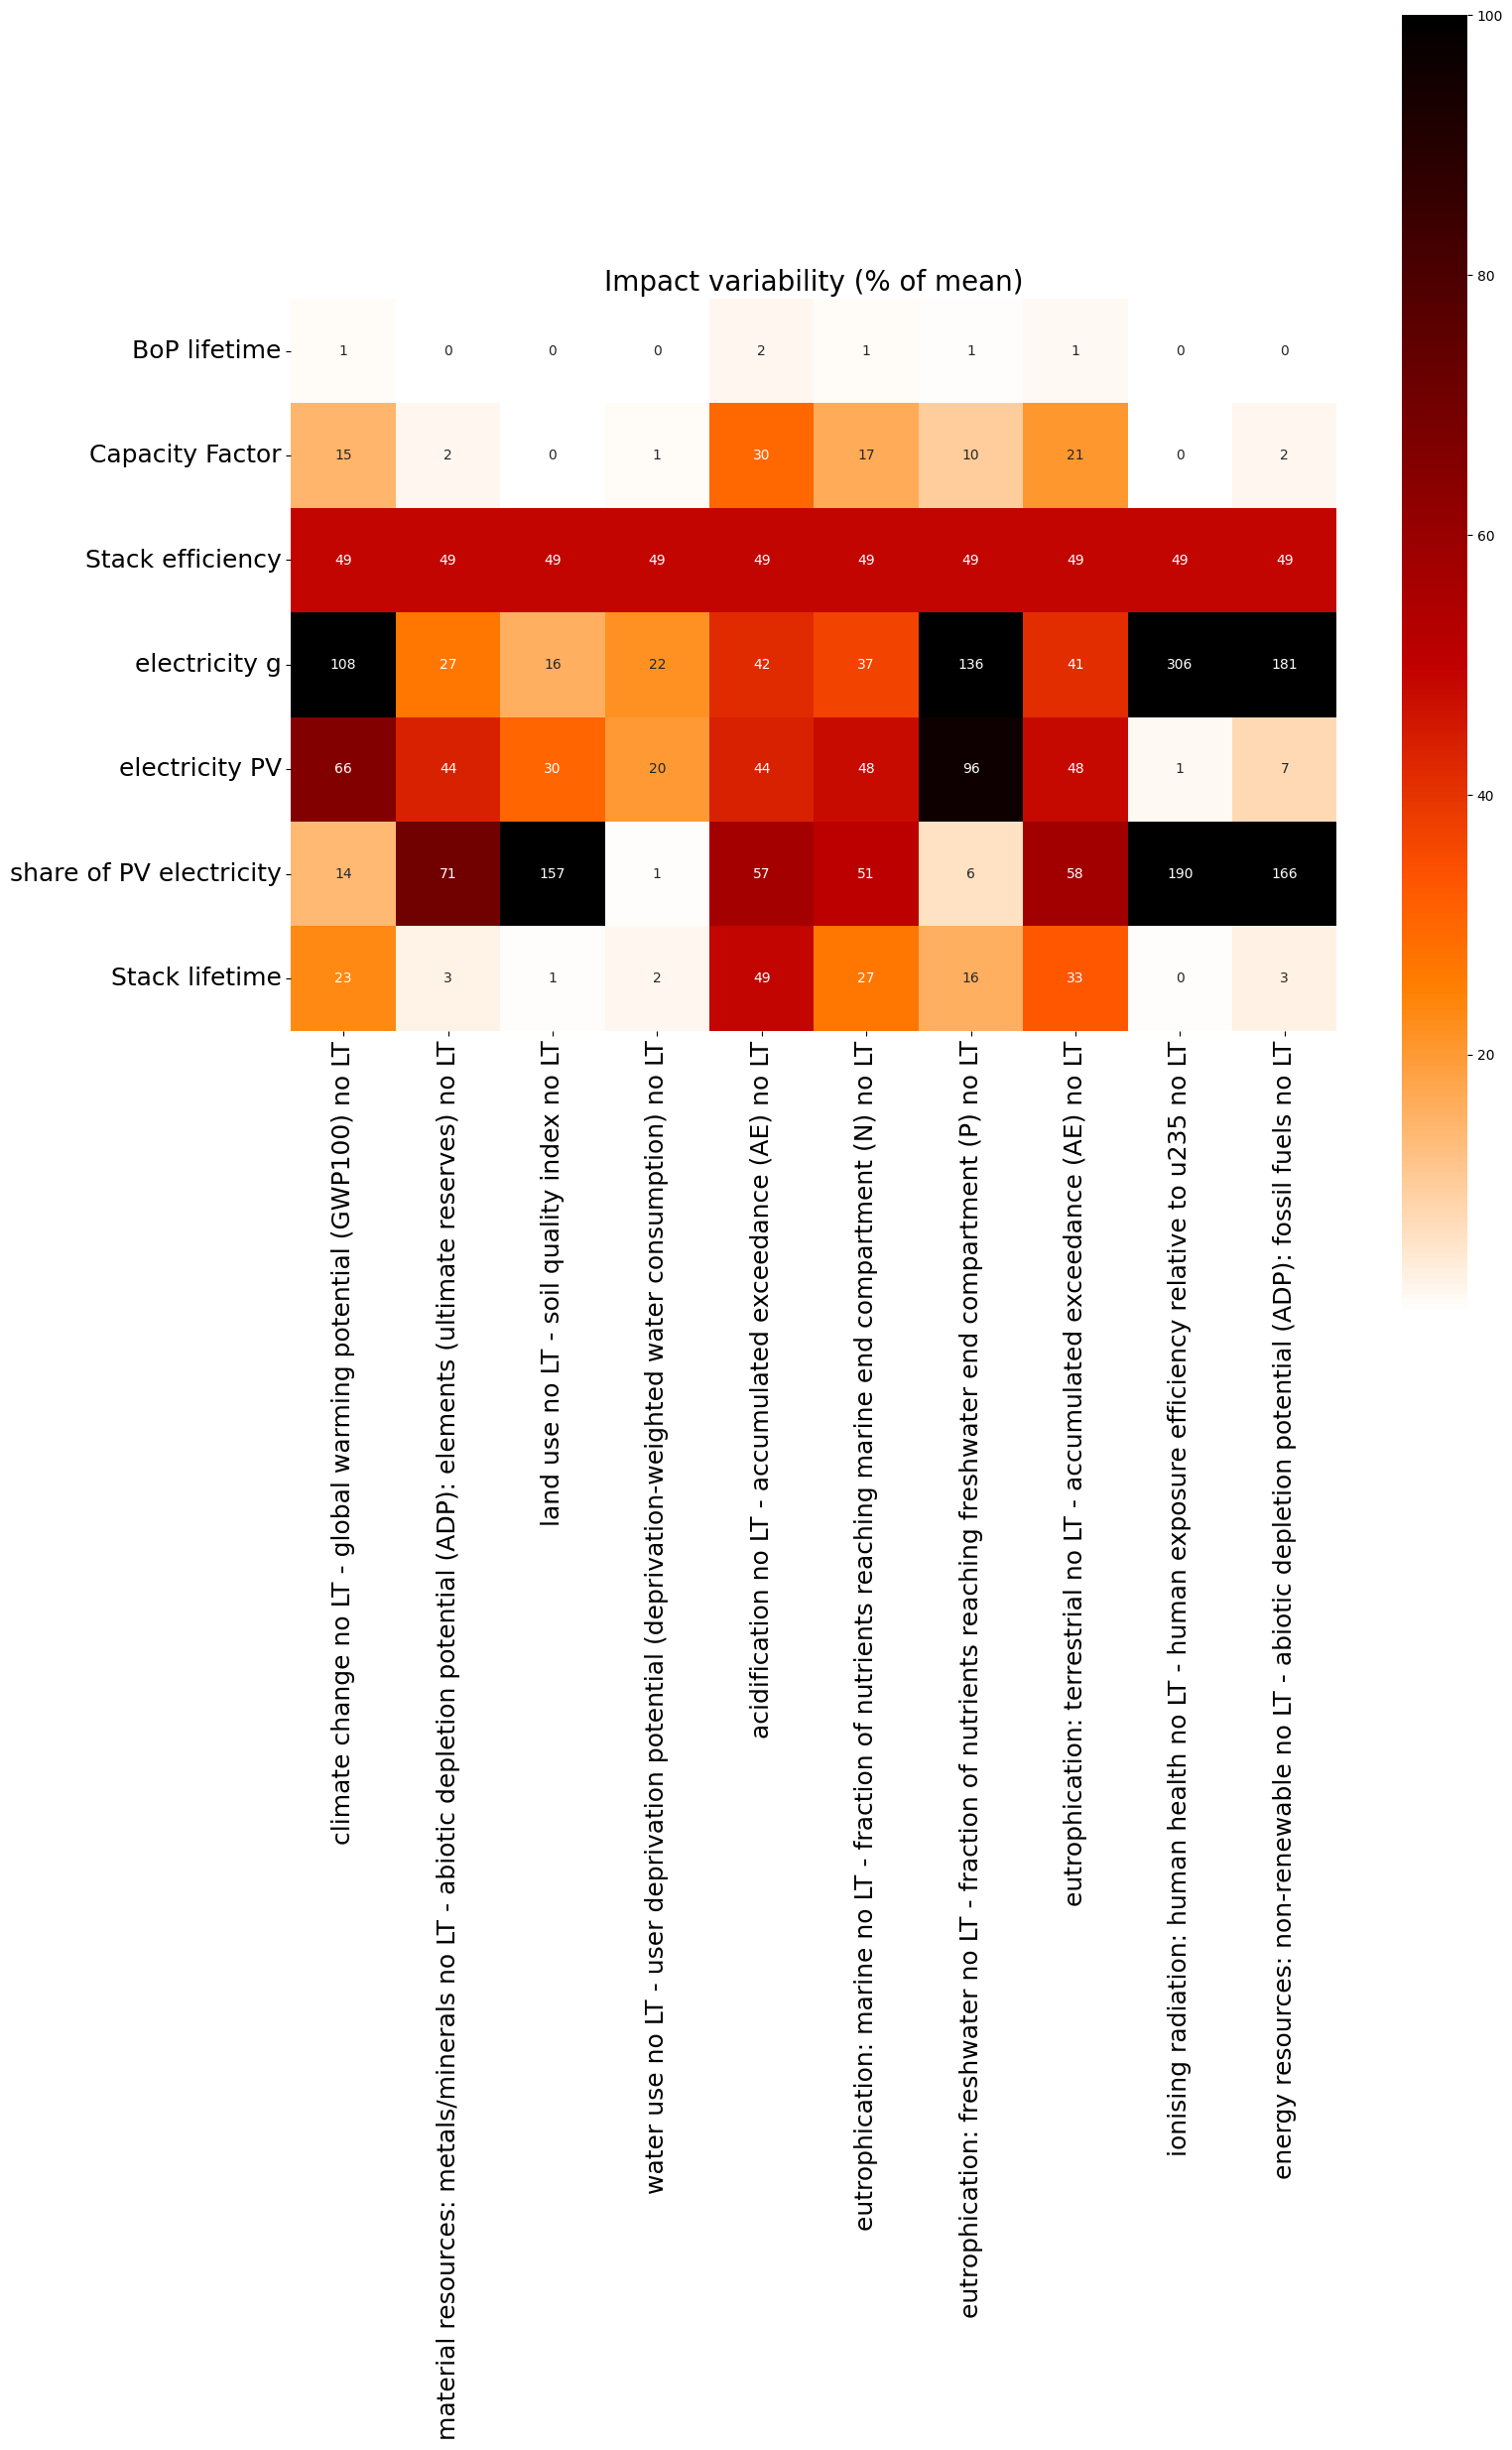

In [11]:
agb.oat_matrix(system_f, IMPACTS)

### Globa Sensitivity Analysis - Global view of relative variation

In [12]:
agb.incer_stochastic_dashboard(system_f, IMPACTS)

[INFO] Db changed recently, clearing cache expr


Generating samples ...
Transforming samples ...
Processing Sobol indices ...
Processing sobol for ('EF v3.1 no LT', 'climate change no LT', 'global warming potential (GWP100) no LT')


C:\local\jsteinbach\Anaconda_3\envs\agb\Lib\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


Processing sobol for ('EF v3.1 no LT', 'material resources: metals/minerals no LT', 'abiotic depletion potential (ADP): elements (ultimate reserves) no LT')
Processing sobol for ('EF v3.1 no LT', 'land use no LT', 'soil quality index no LT')
Processing sobol for ('EF v3.1 no LT', 'water use no LT', 'user deprivation potential (deprivation-weighted water consumption) no LT')
Processing sobol for ('EF v3.1 no LT', 'acidification no LT', 'accumulated exceedance (AE) no LT')
Processing sobol for ('EF v3.1 no LT', 'eutrophication: marine no LT', 'fraction of nutrients reaching marine end compartment (N) no LT')
Processing sobol for ('EF v3.1 no LT', 'eutrophication: freshwater no LT', 'fraction of nutrients reaching freshwater end compartment (P) no LT')
Processing sobol for ('EF v3.1 no LT', 'eutrophication: terrestrial no LT', 'accumulated exceedance (AE) no LT')
Processing sobol for ('EF v3.1 no LT', 'ionising radiation: human health no LT', 'human exposure efficiency relative to u235 no

## Hydrogen LCA using PV data
In the previous assessment, we parametrized the share of PV contribution to the final impact by varying it from 0% to 100%. However, in reality, systems with high capacity factors cannot physically rely entirely on PV electricity due to periods without sunlight. Even with battery storage, it is not feasible to store enough surplus PV electricity to continuously power the electrolyzer.

As a result, such systems can only claim green hydrogen production through a credit allocation system, where grid electricity is considered as coming from PV if there is a temporal match between PV electricity generation and electrolyzer consumption over a defined period.

In the following section of the code, we analyze how different temporal credit allocation criteria affect a system configuration similar to Iberdrola's hydrogen plant in Spain. Specifically, we examine how the share of PV electricity and the choice of database modeling for grid electricity influence LCA results.

### Select fixed values for the foreground parameters:

In [13]:
stack_LT=120000 # hours
BoP_LT_y = 20 # years
eff = 0.72 # efficiency
cf = 0.90 # Capacity facor, how much will the electrolyzer operate? Here we have selected 90% of the time, with 10% of interruption for mainenance

### Electricity consumed, total Hydrogen production calculus and coupled PV system capacity

In [14]:
electro_capacity_MW = 20 #MW
electro_capacity_W = electro_capacity_MW * 1_000_000
electro_capacity_kW =electro_capacity_MW * 1_000
pv_cap_MW = 100 #MW here PV capacity is set to be 100MW but you can adapt this value according to your project
pv_cap_kW=pv_cap_MW*1_000 # this conversion is needed as the PVGIS website requires PV capacity entry in kWp
stack_type = "PEM" # AEC is also available
transp = "Pipeline" # "Truck" still not implemented
storage_choice = "No storage" #"Tank" is also available
n_tanks = 0 # This value can be changed according to the system
HHV_kWhkg = 39.4  # kWh/kg higher heating value for the water -> H2 transformation
BoP_LT_h = BoP_LT_y * 365 * 24 #years conversion to hours
Electricity_consumed_kWh = BoP_LT_h * cf * electro_capacity_kW
H2_produced = BoP_LT_h * cf * electro_capacity_kW * eff / HHV_kWhkg #total H2 produced during the plant's life time
Electricity_1kg = (Electricity_consumed_kWh / H2_produced)  # = HHV/eff  electricity consumed by the stack to produce 1kg of Hydrogen
n_stacks = -(-((BoP_LT_h / stack_LT) * electro_capacity_MW) // 1) # code for rounding up integer as the stacks units needed cannot be floats

### Set PV/Hydrogen plant geolocation:
In case you would like to connect your Hydrogen system with a PV system the geographical location of your plant is required. In this example the latitude and longitude for Fos-sur-Mer is used

In [15]:
geodata = (43.4381, 4.9456)
lat = 43.4381
lon= 4.9456

### PV data from PVGIS
The following code scrapes power data from the PV farm and creates a dataframe that is the avarage of the years 2018, 2019, 2020:

In [16]:
years = [2018, 2019, 2020]
data_frames = []

for year in years:
    URL = f"https://re.jrc.ec.europa.eu/api/v5_2/seriescalc?lat={lat:.3f}&lon={lon:.3f}&raddatabase=PVGIS-SARAH2&browser=1&outputformat=csv&userhorizon=&usehorizon=1&angle=&aspect=&startyear={year}&endyear={year}&mountingplace=free&optimalinclination=0&optimalangles=1&js=1&select_database_hourly=PVGIS-SARAH2&hstartyear={year}&hendyear={year}&trackingtype=0&hourlyoptimalangles=1&pvcalculation=1&pvtechchoice=crystSi&peakpower={pv_cap_kW}&loss=14&components=1"

    r = urlopen(URL)
    o = StringIO(r.read().decode())

    data2 = []
    start_line = 12
    header = ["DateTime", "elec_W"]

    o.seek(0)
    for i, line in enumerate(o):
        if i >= start_line:
            if line.strip() == "":
                break
            columns = line.strip().split(',')
            if len(columns) >= 2:
                data2.append([columns[0], columns[1]])

    df = pd.DataFrame(data2, columns=header)
    df['elec_W'] = pd.to_numeric(df['elec_W'], errors='coerce')
    df['elec_Wh'] = df['elec_W']
    df['DateTime'] = pd.to_datetime(df['DateTime'], format='%Y%m%d:%H%M')

    if year == 2020:
        df = df[~((df['DateTime'].dt.month == 2) & (df['DateTime'].dt.day == 29))] # 2020 is a leap year

    data_frames.append(df)

avg_df = data_frames[0].copy()
avg_df['elec_W'] = sum(df['elec_W'] for df in data_frames) / len(years)
avg_df['elec_Wh'] = avg_df['elec_W']
df['elec_W']= avg_df['elec_W']

### Credit allocation calculation:
The following calculation creates the constraints for the different PV credit allocation variables according to the equations available on the README file.

In [17]:
hours_year = 365 * 24
total_elec_consumed_by_electro_Wh = electro_capacity_W * cf * hours_year  # here we add the capacity factor because this is related to electrolyzer's consumption, this assumes that the maintenance will be done when pv is not producing electricity

y_elec_production_from_PV_Wh = df['elec_Wh'].sum() #total electricity produced by the PV system during that one-year period
capped_values = df['elec_Wh'].clip(upper=electro_capacity_W) #all values under electro_capacity_Wh
capped_sum = (capped_values == electro_capacity_W).sum() * electro_capacity_W
cf_for_only_pv_consumption = capped_sum / (electro_capacity_W * hours_year)
max_direct_pv_consumption_by_electro = capped_values.sum() #consumption of electricity from PV due to direct connection, it doesn't include any electricity due to allocation
#real_direct_pv_consumption_by_electro =
if total_elec_consumed_by_electro_Wh > max_direct_pv_consumption_by_electro:
    h_grid = total_elec_consumed_by_electro_Wh - max_direct_pv_consumption_by_electro #in the hourly allocation rule no PV credit exists
    h_not_claimed_elec = y_elec_production_from_PV_Wh - max_direct_pv_consumption_by_electro  # h_credit, the hourly allocation system doesnt allow any allocation to "seen" due to the hourly resolution od the PV data
else:
    print("Under this configuration, no grid electricity is required.")


# yearly cap begins here:
if y_elec_production_from_PV_Wh >= total_elec_consumed_by_electro_Wh:
    y_elec_consumption_from_PV_Wh = total_elec_consumed_by_electro_Wh #the electrolyzer will never consume more electricity than what its capacity allows, even if the PV is oversized
    y_not_claimed_elec = y_elec_production_from_PV_Wh - total_elec_consumed_by_electro_Wh #in this case there will be surplus electricity that can be sold in the market, or stored, or wasted
elif y_elec_production_from_PV_Wh < total_elec_consumed_by_electro_Wh:
    y_elec_consumption_from_PV_Wh = y_elec_production_from_PV_Wh #in case the PV system is undersized every electricity produced will be consumed under this allocation rule
    y_not_claimed_elec = 0 #no electricity to sell, or store, actually, electricity from the grid will be needed to fulfill capacity

y_credit = y_elec_consumption_from_PV_Wh - max_direct_pv_consumption_by_electro  #this is the share of electricity from the PV, that was sent to the grid, but consumed later as it was claimed as PV sourced under the annual allocation rule
y_grid = total_elec_consumed_by_electro_Wh - (y_credit + max_direct_pv_consumption_by_electro) #in case the electricity produced during the year by the PV system is not enough, grid electricity will be used

# monthly cap begins here:
# Extract month and year part and create a new column YearMonth
df['YearMonth'] = df['DateTime'].dt.to_period('M')

# Group by the month and sum the 'elec_Wh' values
monthly_sums = df.groupby('YearMonth')['elec_Wh'].sum().reset_index()

# Calculate the monthly maximum values based on the number of days in each month
monthly_sums['days_in_month'] = monthly_sums['YearMonth'].dt.days_in_month
monthly_sums['max_value'] = monthly_sums['days_in_month'] * 24 * electro_capacity_W

# Cap the monthly sums
monthly_sums['Total_elec_Wh_month_capped'] = monthly_sums['elec_Wh'].clip(upper=monthly_sums['max_value']) #max electricity consumed from PV for each month

m_elec_consumption_from_PV_Wh = monthly_sums['Total_elec_Wh_month_capped'].sum()  #* cf #total electricity that can be claimed from PV
m_elec_consumption_from_PV_Wh = min (total_elec_consumed_by_electro_Wh, m_elec_consumption_from_PV_Wh)
m_not_claimed_elec = y_elec_production_from_PV_Wh - m_elec_consumption_from_PV_Wh
m_credit = m_elec_consumption_from_PV_Wh - max_direct_pv_consumption_by_electro #this is the share of electricity from the PV, that was sent to the grid, but consumed later as it was claimed as PV sourced under the monthly allocation rule
m_grid = total_elec_consumed_by_electro_Wh - m_elec_consumption_from_PV_Wh

# daily cap begins here:
# Extract date part and create a new column
df['Date'] = df['DateTime'].dt.date

# Group by the date and sum the 'elec_Wh' values
daily_sums = df.groupby('Date')['elec_Wh'].sum().reset_index()

# Rename columns for clarity
daily_sums.columns = ['Date', 'Total_elec_Wh_day']

# Daily cap
max_value = 24 * electro_capacity_W

# Preserve the original column
original_values = daily_sums['Total_elec_Wh_day']

# Clip the column and replace it
daily_sums['Total_elec_Wh_day'] = original_values.clip(upper=max_value)

d_elec_consumption_from_PV_Wh = daily_sums['Total_elec_Wh_day'].sum()
d_elec_consumption_from_PV_Wh = min(total_elec_consumed_by_electro_Wh, d_elec_consumption_from_PV_Wh )

d_not_claimed_elec = y_elec_production_from_PV_Wh - d_elec_consumption_from_PV_Wh
d_credit = d_elec_consumption_from_PV_Wh - max_direct_pv_consumption_by_electro  # this is the share of electricity from the PV, that was sent to the grid, but consumed later as it was claimed as PV sourced under the monthly allocation rule
d_grid = total_elec_consumed_by_electro_Wh - d_elec_consumption_from_PV_Wh

### Plot the different allocation distribution of PV and grid electricity:

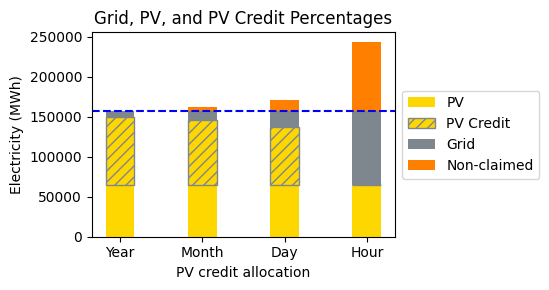

In [18]:
# Define constants for colors
COLOR_PV = '#FFD700'
COLOR_GRID = '#7E868E'
COLOR_NON_CLAIMED = '#ff8000'

# Prepare data for plotting
data = {
    'Category': ['Year', 'Month', 'Day', 'Hour'],
    'Grid': [(y_grid) / 1_000_000, (m_grid) / 1_000_000, (d_grid) / 1_000_000, (h_grid) / 1_000_000],
    'PV Credit': [y_credit / 1_000_000, m_credit / 1_000_000, d_credit / 1_000_000, 0], # No PV credit for hourly
    'PV non claimed': [y_not_claimed_elec / 1_000_000, m_not_claimed_elec / 1_000_000, d_not_claimed_elec / 1_000_000, h_not_claimed_elec / 1_000_000],
    'PV Actual': [max_direct_pv_consumption_by_electro / 1_000_000] * 4,
}

df = pd.DataFrame(data)

# Plot the data
fig, ax = plt.subplots(figsize=(5, 3))
bar_width = 0.35

# Plot bars
bar1 = ax.bar(df['Category'], df['PV Actual'], bar_width, label='PV', color=COLOR_PV)
bar2 = ax.bar(df['Category'], df['PV Credit'], bar_width, bottom=df['PV Actual'], label='PV Credit', color=COLOR_PV, edgecolor=COLOR_GRID, hatch='///')
bar4 = ax.bar(df['Category'], df['Grid'], bar_width, bottom=df['PV Actual'] + df['PV Credit'], label='Grid',
              color=COLOR_GRID)
bar5 = ax.bar(df['Category'], df['PV non claimed'], bar_width,
              bottom=df['PV Actual'] + df['PV Credit'] + df['Grid'],
              label='Non-claimed', color=COLOR_NON_CLAIMED)

# Add labels and title
ax.set_xlabel('PV credit allocation', fontsize=10)
ax.set_ylabel('Electricity (MWh)', fontsize=10)
ax.set_title('Grid, PV, and PV Credit Percentages', fontsize=12)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Add total consumption line
total_consumption = total_elec_consumed_by_electro_Wh / 1_000_000
ax.axhline(y=total_consumption, color='blue', linestyle='--',
           label=f'Total Consumption = {total_consumption:.2f} MWh')

# Adjust layout
plt.tight_layout()
fig.subplots_adjust(right=0.8)

In [19]:
# Define the allocation criteria
allocations = ["Year", "Month", "Day", "Hour"]

# Define the share of grid electricity for each allocation
share_grid_options = {
    "Year": y_grid / total_elec_consumed_by_electro_Wh,
    "Month": m_grid / total_elec_consumed_by_electro_Wh,
    "Day": d_grid / total_elec_consumed_by_electro_Wh,
    "Hour": h_grid / total_elec_consumed_by_electro_Wh,
}

# Compute the share of PV electricity dynamically
share_pv_options = {key: 1 - value for key, value in share_grid_options.items()}

### Check the nem PV and Grid shares
Previously we parametrized the share of PV from 0 to 100% which do not reflec actual PV coupled systems for H2 production

In [20]:
for allocation in allocations:
    share_grid = share_grid_options[allocation]
    share_pv = share_pv_options[allocation]
    print(f"Allocation: {allocation}")
    print(f"  Share Grid: {share_grid:.4f}")
    print(f"  Share PV: {share_pv:.4f}")
    print("-" * 30)

Allocation: Year
  Share Grid: 0.0473
  Share PV: 0.9527
------------------------------
Allocation: Month
  Share Grid: 0.0776
  Share PV: 0.9224
------------------------------
Allocation: Day
  Share Grid: 0.1331
  Share PV: 0.8669
------------------------------
Allocation: Hour
  Share Grid: 0.5903
  Share PV: 0.4097
------------------------------


### Calculate the environmental impacts of Hydrogen production via electrolysis
The LCA will be calculated to hydrogen systems that consume grid electricity from each RTE scenario and IAM applied, scenarios without the use of IAMs are also available. For each case the four PV credit allocation rule was applied resulting in a 24 x 4 matrix (6 RTE scenarios, 4 different databases, 4 credit allocation scenarios)

In [21]:
scenarios = {
    "T45": (T45, "PV_T45"),
    "TB": (TB, "PV_TB"),
    "IB": (IB, "PV_IB"),
    "NI": (NI, "PV_NI"),
}

### Climate change

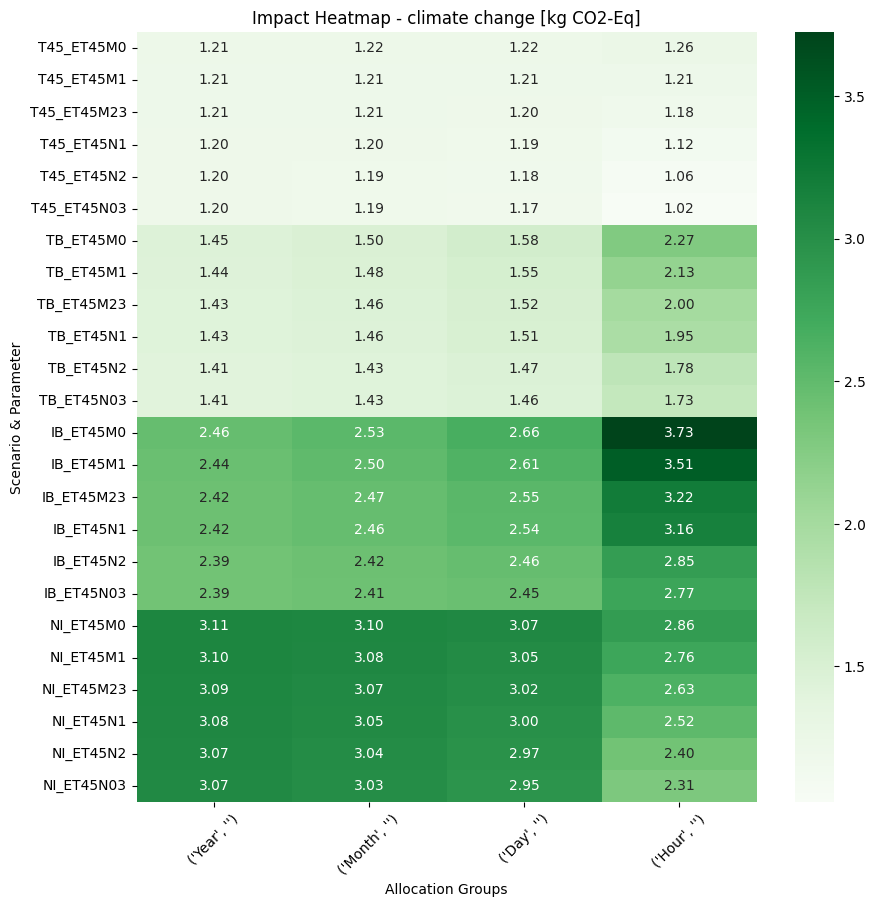

In [22]:
# Initialize dictionary for results
final_results = {}

# Compute impacts for each scenario and allocation group
for scenario, (grid_param, pv_param) in scenarios.items():
    final_results[scenario] = pd.concat({
        allocation: agb.compute_impacts(
            system_f, climate, param_g=grid_param, param_pv=pv_param, 
            share_PV=share_pv_options[allocation], eff=eff, cf=cf, 
            BoP_LT_y=BoP_LT_y, stack_LT=stack_LT
        ).rename(columns={'climate change no LT - global warming potential (GWP100) no LT[kg CO2-Eq]': ''})
        for allocation in allocations
    }, axis=1)

# Create heatmap data matrix
scenarios_list = list(final_results.keys())
df_sample = final_results[scenarios_list[0]]
num_rows, num_cols = df_sample.shape[0] * len(scenarios_list), df_sample.shape[1]
heatmap_matrix = np.vstack([final_results[scn].values for scn in scenarios_list])

# Generate row labels dynamically
row_labels = [f"{scn}_{row}" for scn in scenarios_list for row in df_sample.index]

# Plot the heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(
    heatmap_matrix, cmap="Greens", annot=True, fmt=".2f",
    xticklabels=df_sample.columns, yticklabels=row_labels
)

plt.xlabel("Allocation Groups")
plt.ylabel("Scenario & Parameter")
plt.title("Impact Heatmap - climate change [kg CO2-Eq]")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

### Land Use

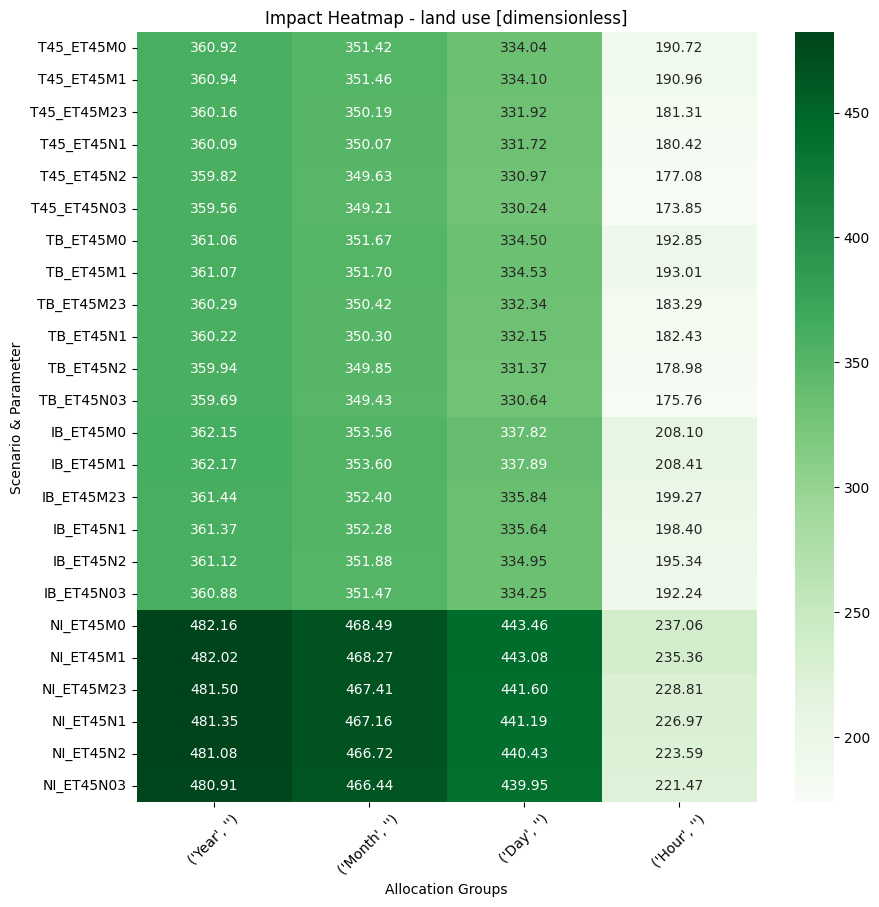

In [23]:
# Initialize dictionary for results
final_results = {}

# Compute impacts for each scenario and allocation group
for scenario, (grid_param, pv_param) in scenarios.items():
    final_results[scenario] = pd.concat({
        allocation: agb.compute_impacts(
            system_f, land, param_g=grid_param, param_pv=pv_param, 
            share_PV=share_pv_options[allocation], eff=eff, cf=cf, 
            BoP_LT_y=BoP_LT_y, stack_LT=stack_LT
        ).rename(columns={'land use no LT - soil quality index no LT[dimensionless]': ''})
        for allocation in allocations
    }, axis=1)

# Create heatmap data matrix
scenarios_list = list(final_results.keys())
df_sample = final_results[scenarios_list[0]]
num_rows, num_cols = df_sample.shape[0] * len(scenarios_list), df_sample.shape[1]
heatmap_matrix = np.vstack([final_results[scn].values for scn in scenarios_list])

# Generate row labels dynamically
row_labels = [f"{scn}_{row}" for scn in scenarios_list for row in df_sample.index]

# Plot the heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(
    heatmap_matrix, cmap="Greens", annot=True, fmt=".2f",
    xticklabels=df_sample.columns, yticklabels=row_labels
)

plt.xlabel("Allocation Groups")
plt.ylabel("Scenario & Parameter")
plt.title("Impact Heatmap - land use [dimensionless]")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

### Ionising radiation

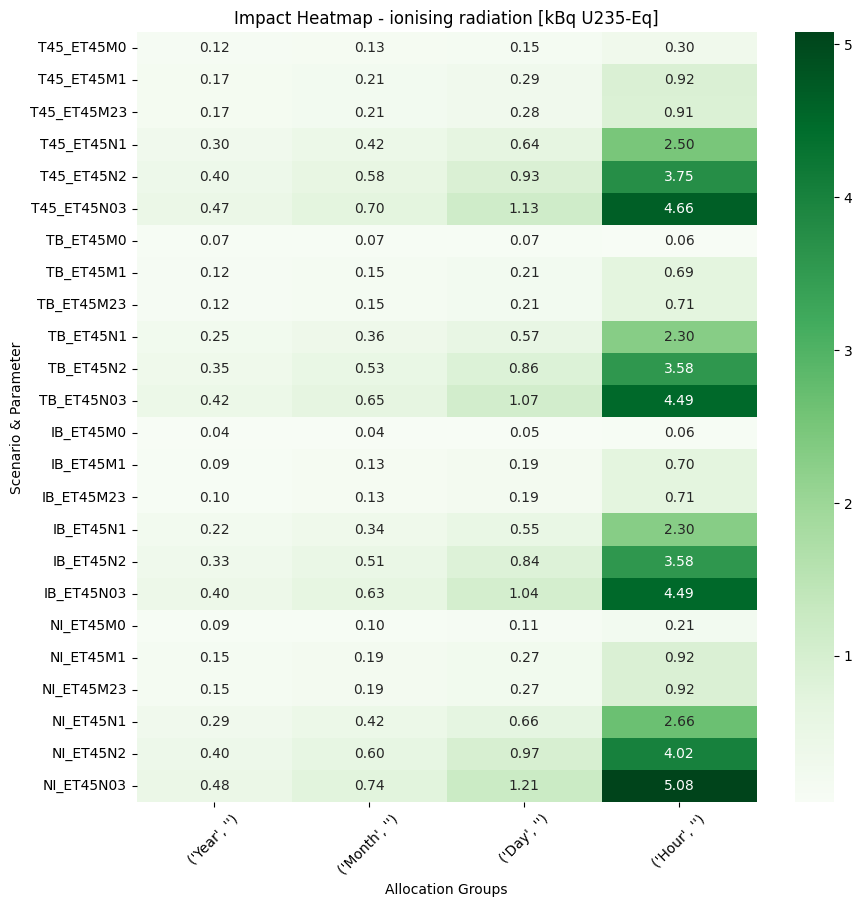

In [24]:
# Initialize dictionary for results
final_results = {}

# Compute impacts for each scenario and allocation group
for scenario, (grid_param, pv_param) in scenarios.items():
    final_results[scenario] = pd.concat({
        allocation: agb.compute_impacts(
            system_f, 
            radiation, 
            param_g=grid_param, param_pv=pv_param, 
            share_PV=share_pv_options[allocation], eff=eff, cf=cf, BoP_LT_y=BoP_LT_y, stack_LT=stack_LT
        ).rename(columns={'ionising radiation: human health no LT - human exposure efficiency relative to u235 no LT[kBq U235-Eq]': ''})
        for allocation in allocations
    }, axis=1)

# Create heatmap data matrix
scenarios_list = list(final_results.keys())
df_sample = final_results[scenarios_list[0]]
num_rows, num_cols = df_sample.shape[0] * len(scenarios_list), df_sample.shape[1]
heatmap_matrix = np.vstack([final_results[scn].values for scn in scenarios_list])

# Generate row labels dynamically
row_labels = [f"{scn}_{row}" for scn in scenarios_list for row in df_sample.index]

# Plot the heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(
    heatmap_matrix, cmap="Greens", annot=True, fmt=".2f",
    xticklabels=df_sample.columns, yticklabels=row_labels
)

plt.xlabel("Allocation Groups")
plt.ylabel("Scenario & Parameter")
plt.title("Impact Heatmap - ionising radiation [kBq U235-Eq]")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()